# Reconstruction of photon number distribuiton with photon number resolving detectors

In [1]:
# Reproduction of some previous work

import numpy as np
import numpy.typing as npt
from typing import Optional
from collections.abc import Sequence
import scipy as sp
from scipy.special import comb, factorial, eval_hermite
import cvxpy as cp
from multiprocessing import Pool
from itertools import product, combinations
from tqdm.notebook import trange
import utils

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from matplotlib.figure import figaspect

In [116]:
# utility function

def _loss_matrix(eta: float, M: int) -> npt.NDArray[float]:
    '''
    Args:
        eta: float, the efficiency of the detector.
        M: int, the photon number at which the Fock space truncated.
    Return:
        L: 2darray, the loss matrix.
    '''
    if eta==1:
        L = np.identity(M+1)
    else:
        L = np.empty((M+1, M+1))
        for i, j in product(range(M+1), repeat=2):
            L[i,j] = comb(j, i) * eta**i * (1-eta)**(j-i)
    return L

## 1.1 Banaszek, K. Maximum-likelihood estimation of photon-number distribution from homodyne statistics. Phys. Rev. A 57, 5013–5015 (1998).

In [65]:
class Homodyne():
    def __init__(self, K: int = 19, eta: float = .85):
        '''
        Attributes:
            K: int, truncated at photon number K.
            eta: float, detection efficiency.
        '''
        self.K = K
        self.eta = eta
        self.x = np.linspace(-5, 5, num=101, endpoint=False)
        self.x += .05 # the central point of each bin.

    def A(self) -> npt.NDArray[float]:
        '''
        Eq(2) in the paper.
        Returns:
            A_: 2darray of shape (len(x), K+1)
        '''
        A_ = np.zeros((len(self.x), self.K+1))
        for n in range(self.K+1):
            for m in range(n+1):
                A_[:, n] += comb(n, m) * (1-self.eta)**(n-m)*self.eta**m/(np.sqrt(np.pi)*2**m*factorial(m)) * eval_hermite(m, self.x)**2
            A_[:, n] *= np.exp(-self.x**2)
        return A_
    
    def Monte_Carlo(self, rho: npt.NDArray[float], N: int = int(1e5)) -> npt.NDArray[float]:
        '''
        Monte Carlo simulations of the homodyne experiment.
        Args:
            rho: 1darray, the input distribution.
            N: int, number of samples, default int(1e5).
        Returns:
            hist: 1darray, the measured histogram.
        '''
        p = self.A()@rho
        # p /= p.sum() # make sure that p sums to 1.
        rng = np.random.default_rng()
        samples = rng.choice(len(p), size=N, p=p)
        hist, _ = np.histogram(samples, bins=np.arange(len(p)+1))
        return hist
        
def neg_Lag(y, hist, A, N: int = int(1e5)) -> float:
    '''
    Negative_Lagrangian to be minimized, refer fo Eq. (5) and Eq. (6) in the paper.
    Parameters:
        y: 1darray of shape (K+1,), the parameters to be optimized.
        hist: 1darray of shape (num_bin,), the measured histogram.
        A: 2darray of shape (num_bin, K+1), the matrix in Eq. (2).
        N: int, the number of samples, default int(1e5).
    Returns:
        nL: float, negative Lagrangian.
    '''
    rho = y**2
    p = A@rho
    nL = - hist@np.log(p) + N*rho.sum()
    return nL

Optimization terminated successfully.
         Current function value: 255171.460674
         Iterations: 25407
         Function evaluations: 31619
Optimization terminated successfully.
         Current function value: 253940.146737
         Iterations: 8788
         Function evaluations: 11042


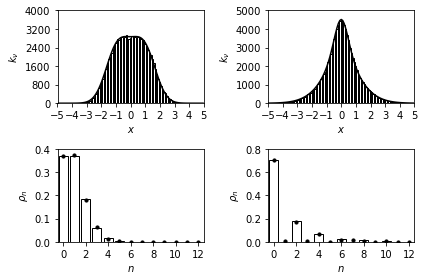

In [115]:
nbar = 1
K = 19
homodyne = Homodyne()
A = homodyne.A()

# Reconstruct the coherent state
rho1 = utils.rho(nbar, K, 'coherent')
hist1 = homodyne.Monte_Carlo(rho1)
hist1_theo = A@rho1*0.1*1e5 # Eq. (3)
res1 = sp.optimize.minimize(neg_Lag, np.full(K+1, 1/np.sqrt(K+1)), args=(hist1, A), method='Nelder-Mead', options={'maxfev':int(1e5), 'disp':True})
rho1_reconstr = res1.x**2

# Reconstruct the queezed vacuum state
rho2 = utils.rho(nbar, K, 'squeezed_vacuum')
hist2 = homodyne.Monte_Carlo(rho2)
hist2_theo = A@rho2*0.1*1e5 # Eq. (3)
res2 = sp.optimize.minimize(neg_Lag, np.full(K+1, 1/np.sqrt(K+1)), args=(hist2, A), method='Nelder-Mead', options={'maxfev':int(1e5), 'disp':True})
rho2_reconstr = res2.x**2

# Plot
n = range(13)
fig, axs = plt.subplots(2, 2, tight_layout=True)
axs[0,0].bar(homodyne.x, hist1, width=.1, color='w', edgecolor='k')
axs[0,0].plot(homodyne.x, hist1_theo, 'k')
axs[0,0].set_xlim((-5, 5))
axs[0,0].set_ylim((0, 4000))
axs[0,0].set_xlabel('$x$')
axs[0,0].set_ylabel(r'$k_{\nu}$')
axs[0,0].yaxis.set_major_locator(MultipleLocator(800))
axs[0,0].xaxis.set_major_locator(MultipleLocator(1))

axs[1,0].bar(n, rho1[:len(n)], color='w', edgecolor='k')
axs[1,0].scatter(n, rho1_reconstr[:len(n)], s=10, color='k')
axs[1,0].set_xlim(-.5, 12.5)
axs[1,0].set_ylim(0, .4)
axs[1,0].set_xlabel('$n$')
axs[1,0].set_ylabel(r'$\rho_n$')
axs[1,0].xaxis.set_major_locator(MultipleLocator(2))

axs[0,1].bar(homodyne.x, hist2, width=.1, color='w', edgecolor='k')
axs[0,1].plot(homodyne.x, hist2_theo, 'k')
axs[0,1].set_xlim((-5, 5))
axs[0,1].set_ylim((0, 5000))
axs[0,1].set_xlabel('$x$')
axs[0,1].set_ylabel(r'$k_{\nu}$')
axs[0,1].xaxis.set_major_locator(MultipleLocator(1))
axs[0,1].yaxis.set_major_locator(MultipleLocator(1000))

axs[1,1].bar(n, rho2[:len(n)], color='w', edgecolor='k')
axs[1,1].scatter(n, rho2_reconstr[:len(n)], s=10, color='k')
axs[1,1].set_xlim(-.5, 12.5)
axs[1,1].set_ylim(0, .8)
axs[1,1].set_xlabel('$n$')
axs[1,1].set_ylabel(r'$\rho_n$')
axs[1,1].xaxis.set_major_locator(MultipleLocator(2))
fig.savefig('./Reproduction/Banaszek1998/Figures/Fig1.pdf')

## 1.2 Banaszek, K. Reconstruction of photon distribution with positivity constraints. Acta Physica Slovaca 48, 185–190 (1998).

In [106]:
def EM(hist: npt.NDArray[float], A: npt.NDArray[float], K: int = 20, N: int = int(1e5), num_iter: int = 8000) -> npt.NDArray[float]:
    '''
    Eq. (5) in the paper, a special case of the EM algorithm.
    Args:
        A: 2darray, the matrix that transform the input distribution to the homodyne statistics.
        K: int, the number state at which the input state truncates, default 20.
        N: int, the number of samples, default int(1e5).
        num_iter: int, the number of iterations, default 8000.
    Returns:
        rho: 1darray, the optimized distribution.
    '''
    rho = np.full(K+1, 1/(K+1))
    for _ in range(num_iter):
        p = A@rho
        rho *= hist/(N*p)@A
    return rho

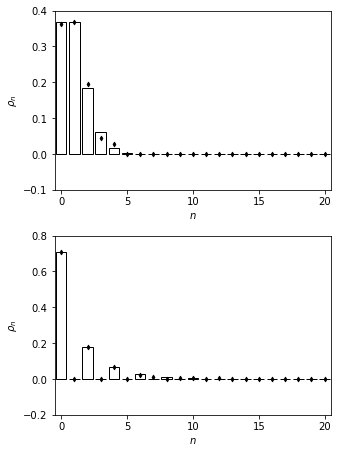

In [117]:
nbar = 1
K = 20
homodyne = Homodyne(K)
A = homodyne.A()

# Reconstruct the coherent state
rho1 = utils.rho(nbar, K, 'coherent')
hist1 = homodyne.Monte_Carlo(rho1)
rho1_reconstr = EM(hist1, A)

# Reconstruct the queezed vacuum state
rho2 = utils.rho(nbar, K, 'squeezed_vacuum')
hist2 = homodyne.Monte_Carlo(rho2)
rho2_reconstr = EM(hist2, A)

# Plot
n = range(21)
fig, axs = plt.subplots(2, 1, tight_layout=True, figsize=(4.8, 6.4))
axs[0].bar(n, rho1, color='w', edgecolor='k')
axs[0].scatter(n, rho1_reconstr, s=10, color='k', marker='d')
axs[0].set_xlim(-.5, 20.5)
axs[0].set_ylim(-.1, .4)
axs[0].set_xlabel('$n$')
axs[0].set_ylabel(r'$\rho_n$')
axs[0].xaxis.set_major_locator(MultipleLocator(5))
axs[0].yaxis.set_major_locator(MultipleLocator(.1))

axs[1].bar(n, rho2, color='w', edgecolor='k')
axs[1].scatter(n, rho2_reconstr, s=10, color='k', marker='d')
axs[1].set_xlim(-.5, 20.5)
axs[1].set_ylim(-.2, .8)
axs[1].set_xlabel('$n$')
axs[1].set_ylabel(r'$\rho_n$')
axs[1].xaxis.set_major_locator(MultipleLocator(5))
axs[1].yaxis.set_major_locator(MultipleLocator(.2))
fig.savefig('./Reproduction/Banaszek1998a/Figures/Fig1.pdf')

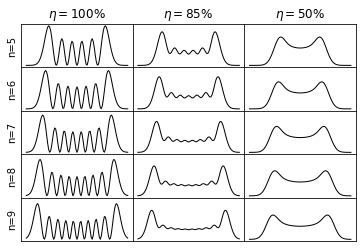

In [161]:
eta = [1, .85, .5]
n = np.arange(5, 10)

fig, axs = plt.subplots(5, 3, sharex=True, sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)
for j in range(3):
    A = Homodyne(K, eta[j]).A()
    for i in range(5):
        axs[i, j].plot(A[:, n[i]], 'k', lw=1)
        if i==0:
            axs[i, j].set_title(f'$\eta={eta[j]*100:.0f}\%$')
        if j==0:
            axs[i, j].set_ylabel(f'n={n[i]}')
        axs[i, j].xaxis.set_ticks([])
        axs[i, j].yaxis.set_ticks([])
fig.savefig('./Reproduction/Banaszek1998a/Fig2.pdf')

## 2. Fitch, M. J., Jacobs, B. C., Pittman, T. B. & Franson, J. D. Photon-number resolution using time-multiplexed single-photon detectors. Phys. Rev. A 68, 043814 (2003).

In [2]:
from sympy import IndexedBase, Poly

class operator_transform():
    def __init__(self, n: int, f: float, eta: float):
        '''
        Args:
            n: int, the number of incident photons.
            f: float, the transmission rate of the fiber of length L.
            eta: float, the APD efficiency.
        Additional attributes:
            state_dict: dict, where the keys represent the states and the values represent the corresponding amplitudes.
        '''
        self.n = n
        self.f = f
        self.eta = eta
        
    def state(self):
        '''
        Calculate the state after all the operator transformations been applied.
        represent $a^\dagger$ with symbol a;
        represent subscript s,l of $a^\dagger$ with index 0,1 of symbol a;
        represent the loss mode in the ith loss-BS with b[i-1];
        omit the |0> on the right-hand side.
        '''
        a = IndexedBase('a')
        b = IndexedBase('b')

        # incident state
        operator = 1/np.sqrt(np.math.factorial(self.n))*a**self.n

        # after 1st BS and after loss-BS in path l
        operator = operator.subs(a, 1/np.sqrt(2)*(a[0] + (np.sqrt(self.f)*a[1] + np.sqrt(1-self.f)*b)))

        # after 2nd BS and after loss-BS in path l
        replacement = [(a[i], 1/np.sqrt(2)*(a[i,0] + (np.sqrt(self.f**2)*a[i,1] + np.sqrt(1-self.f**2)*b[i]))) for i in range(2)]
        operator = operator.subs(replacement)

        # after 3rd BS and after loss-BS in l path
        replacement = [(a[i,j], 1/np.sqrt(2)*(a[i,j,0] + (np.sqrt(self.f**4)*a[i,j,1] + np.sqrt(1-self.f**4)*b[i,j]))) for i,j in product(range(2), repeat=2)]
        operator = operator.subs(replacement)

        # after 4th BS
        replacement = [(a[i,j,k], 1/np.sqrt(2)*(a[i,j,k,0] + a[i,j,k,1])) for i,j,k in product(range(2), repeat=3)]
        operator = operator.subs(replacement)

        state_dict = Poly(operator, *([a[i,j,k,l] for i,j,k,l in product(range(2), repeat=4)] + [b, b[0], b[1]] + [b[i,j] for i,j in product(range(2), repeat=2)])).as_dict()
        for key in state_dict:
            for i in key:
                if i>1:
                    state_dict[key] *= np.sqrt(np.math.factorial(i))
        self.state_dict = state_dict

    def measured_statistics(self):
        def P_A(eta, q):
            return 1 - (1-eta)**q
        
        p = np.zeros((self.n+1,)) # measured statistics
        for key in self.state_dict:
            click_prob_list = [] # click probability of modes with photons
            for i in key[:16]:
                if i>0:
                    click_prob_list.append(P_A(self.eta, i))

            m = len(click_prob_list) # n incident photons distributed into m modes that are not lost due to fiber loss
            if m==0:
                p[0] += self.state_dict[key]**2
            else:
                click_prob_array = np.array(click_prob_list)
                for i in range(m+1):
                    i_clicks_prob = 0
                    for idx1 in combinations(range(m), i):
                        idx1 = list(idx1) # idx1 represents indices of modes that caused click
                        idx2 = list(set(range(m)).difference(set(idx1))) # idx2 represents indices of modes that caused no click
                        i_clicks_prob += np.prod(click_prob_array[idx1]) * np.prod(1-click_prob_array[idx2])
                    p[i] += self.state_dict[key]**2 * i_clicks_prob
        return p

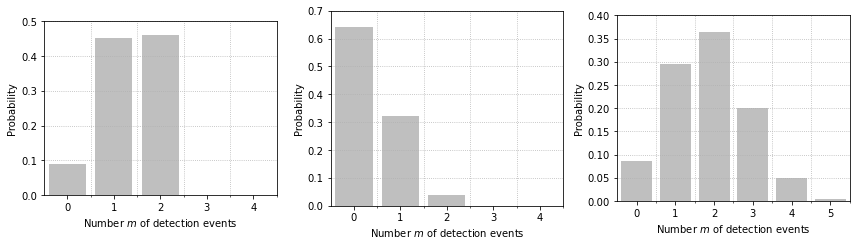

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)

# Fig. 2
optr = operator_transform(2, 1, .7)
optr.state()
p = optr.measured_statistics()
axs[0].bar(x=range(5), height=np.concatenate((p, np.zeros(2,))), color='0.75')
axs[0].set_xlabel('Number $m$ of detection events')
axs[0].set_ylabel('Probability')
axs[0].set_xlim(-0.5, 4.5)
axs[0].set_ylim(0, 0.5)
axs[0].xaxis.set_minor_locator(AutoMinorLocator(2))
axs[0].xaxis.grid(which='minor', linestyle=':')
axs[0].yaxis.grid(linestyle=':')
axs[0].set_aspect(7.5)

# Fig. 3
optr = operator_transform(2, 1, .2)
optr.state()
p = optr.measured_statistics()
axs[1].bar(x=range(5), height=np.concatenate((p, np.zeros(2,))), color='0.75')
axs[1].set_xlabel('Number $m$ of detection events')
axs[1].set_ylabel('Probability')
axs[1].set_xlim(-0.5, 4.5)
axs[1].set_ylim(0, 0.7)
axs[1].xaxis.set_minor_locator(AutoMinorLocator(2))
axs[1].xaxis.grid(which='minor', linestyle=':')
axs[1].yaxis.grid(linestyle=':')
axs[1].set_aspect(6)

# Fig. 4
optr = operator_transform(5, .97, .43)
optr.state()
p = optr.measured_statistics()
axs[2].bar(x=range(6), height=p, color='0.75')
axs[2].set_xlabel('Number $m$ of detection events')
axs[2].set_ylabel('Probability')
axs[2].set_xlim(-0.5, 5.5)
axs[2].set_ylim(0, 0.4)
axs[2].xaxis.set_minor_locator(AutoMinorLocator(2))
axs[2].xaxis.grid(which='minor', linestyle=':')
axs[2].yaxis.grid(linestyle=':')
axs[2].set_aspect(12)

fig.savefig('./Reproduction/Fitch2003/figures/Fig2-3-4.pdf')

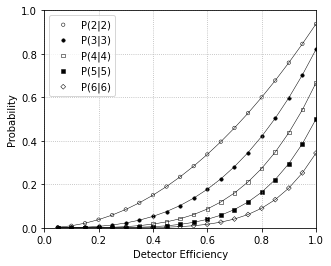

In [12]:
# Fig. 5
n = np.arange(2,7)
eta = np.arange(0.05, 1.05, step=0.05)

p_array = np.empty((len(n), len(eta)))
p_array_analytic = np.empty((len(n), len(eta)))
for idx1, i in enumerate(n):
    state_dict = state(n=i, f=1)
    for idx2, j in enumerate(eta):
        p = measured_statistics(n=i, state_dict=state_dict, eta=j)
        p_array[idx1, idx2] = p[i]
        p_array_analytic[idx1, idx2] = np.math.factorial(16)/(16.**i*np.math.factorial(16-i))*eta[idx2]**i
        # in the denominator, float type of is important to avoid overflow in long_scalars
        
np.savez_compressed('./Reproduction/Fitch2003/data/Fig5.npz', eta=eta, p_array=p_array)

fig, ax = plt.subplots()
marker = ['o', 'o', 's', 's', 'D']
c = ['none', 'k', 'none', 'k', 'none']
for i in range(p_array.shape[0]):
    ax.scatter(eta, p_array[i], s=12, c=c[i], label=f'P({i+2}|{i+2})', marker=marker[i], linewidths=0.5, edgecolors='k')
    ax.plot(eta, p_array_analytic[i], 'k', linewidth=0.5)
ax.legend()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.grid(linestyle=':')
ax.set_aspect(0.8)
ax.set_xlabel('Detector Efficiency')
ax.set_ylabel('Probability')
fig.savefig('./Reproduction/Fitch2003/figures/Fig5.pdf')

## 3.1 Achilles, D. et al. Photon-number-resolving detection using time-multiplexing. Journal of Modern Optics 51, 1499–1515 (2004). 

In [2]:
class Achilles2003():
    def __init__(self, eta, N: int = 8, M: int = 8, S: int = int(1e4)):
        '''
        Attributes:
            eta: float, detector efficiency.
            N: int, the number of bins of the detector, default 8.
            M: int, the number state at which the input state truncates, default 8.
            S: int, the number of samples of Monte Carlo simulation, default int(1e4).
            C: 2darray, the conditional matrix.
            L: 2darray, the loss matrix.
        '''
        self.eta = eta
        self.N = N
        self.M = M
        self.S = S
        self.C = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0], 
              [0, 1, .126, .016, .002, 0, 0, 0, 0], 
              [0, 0, .875, .330, .097, .026, .007, .002, 0], 
              [0, 0, 0, .655, .494, .260, .118, .050, .020], 
              [0, 0, 0, 0, .408, .512, .420, .285, .175], 
              [0, 0, 0, 0, 0, .203, .383, .449, .423], 
              [0, 0, 0, 0, 0, 0, .076, .200, .317], 
              [0, 0, 0, 0, 0, 0, 0, .019, .066], 
              [0, 0, 0, 0, 0, 0, 0, 0, .002]]) # ref Eq(5) in Achilles, D. et al. Photon-number-resolving detection using time-multiplexing. Journal of Modern Optics 51, 1499–1515 (2004).
        self.L = _loss_matrix(eta, M)

    def Monte_Carlo(self, rho: npt.NDArray[float]) -> npt.NDArray[float]:
        '''
        Parameters:
            rho: 1darray, input distribution.
        Returns:
            hist: 1darray, the measured histogram
        '''
        p = self.C@rho
        p /= p.sum()
        rng = np.random.default_rng()
        samples = rng.choice(len(p), size=self.S, p=p)
        hist, _ = np.histogram(samples, bins=np.arange(len(p)+1))
        return hist

    def errbar(self, rho: npt.NDArray[float], num_MC: int = 1000) -> npt.NDArray[float]:
        '''
        Determin the error bars.
        Args:
            rho: 1darray, input distribution.
            num_MC: the number of Monte Carlo simulations, default 1000.
        Returns:
            err: 1darray, error bars of the reconstructed state.
        '''
        P = np.empty((num_MC, self.N+1))
        for i in range(num_MC):
            P[i] = self.Monte_Carlo(rho)
        P /= self.S

        # reconstruct by direct inversion
        Rho_reconstr = P@np.linalg.inv(self.C).T
        err = Rho_reconstr.std(axis=0)
        return err

    def NLL(self, mu: float, hist: npt.NDArray[float]) -> float: 
        '''
        Negative log likelihood function.
        Assume Poissonian distributions, estimate the mean of the detected data.
        Args:
            mu: float, average photon number to be optimized.
            hist: 1darray, measured statistics.
        '''
        rho = utils.rho(mu, self.M, 'coherent')
        p = self.C@rho
        nLL = - hist@np.log(p)
        return nLL
    
    def p_tilde(self, rho: npt.NDArray[float], l: int) -> float:
        '''
        Returns the inverse conditional probability $\tilde{p}(n=l|k=l)$. 
        See Eq. (14) in the paper.
        Args:
            rho: 1darray, input distribution.
            l: int, the number of photons detected.
        '''
        return (self.C@self.L)[l,l] / (self.C@self.L@rho)[l] * rho[l]

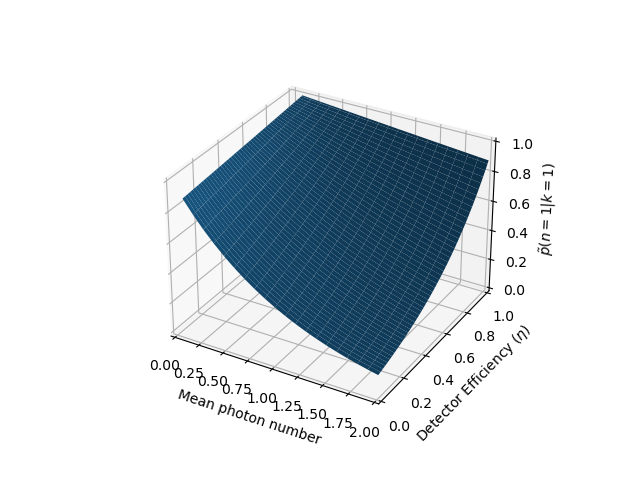

In [3]:
%matplotlib widget

nbar = np.linspace(.1, 2, 20)
eta = np.linspace(.01, 1, 100)
p_tilde = np.empty((len(nbar), len(eta)))
for i, n_ in enumerate(nbar):
    for j, e_ in enumerate(eta):
        p_tilde[i, j] = Achilles2003(e_).p_tilde(utils.rho(n_, 8, 'coherent'), 1)
fig, ax = plt.subplots(subplot_kw={'projection':'3d'})
nbar, eta = np.meshgrid(nbar, eta, indexing='ij')
ax.plot_surface(nbar, eta, p_tilde)
ax.set_xlim(0, 2)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
ax.set_xlabel('Mean photon number')
ax.set_ylabel('Detector Efficiency ($\eta$)')
ax.set_zlabel(r'$\tilde{p}(n=1|k=1)$')
fig.savefig('./Reproduction/Achilles2004/Figures/Fig11.pdf')

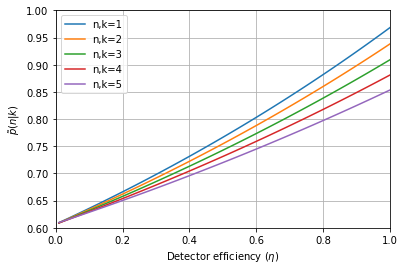

In [11]:
%matplotlib inline
eta = np.linspace(.01, 1, 100)
p_tilde = np.empty((5, len(eta)))
for i in range(5):
    for j, e_ in enumerate(eta):
        p_tilde[i, j] = Achilles2003(e_).p_tilde(utils.rho(.5, 8, 'coherent'), i+1)
fig, ax = plt.subplots()
for i in range(5):
    ax.plot(eta, p_tilde[i], label=f'n,k={i+1}')
ax.legend()
ax.grid()
ax.set_xlim(0, 1)
ax.set_ylim(.6, 1)
ax.set_xlabel('Detector efficiency ($\eta$)')
ax.set_ylabel(r'$\tilde{p}(n|k)$')
fig.savefig('./Reproduction/Achilles2004/Figures/Fig12.pdf')

## 3.2 Achilles, D., Silberhorn, C., Śliwa, C., Banaszek, K. & Walmsley, I. A. Fiber-assisted detection with photon number resolution. Opt. Lett., 28, 2387–2389 (2003).  

The mean square differences between the distributions with mean photon number of 2: 2.96e-04.


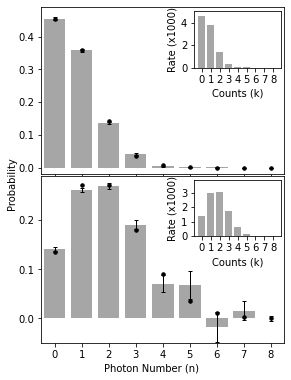

In [204]:
model = Achilles2003()

rho1 = utils.rho(.79, 8, 'coherent')
p1 = model.Monte_Carlo(rho1) / model.S
rho1_reconstr = np.linalg.inv(model.C)@p1
err1 = model.errbar(rho1)

rho2 = utils.rho(2, 8, 'coherent')
p2 = model.Monte_Carlo(rho2) / model.S
rho2_reconstr = np.linalg.inv(model.C)@p2
err2 = model.errbar(rho2)
print(f'The mean square differences between the distributions with mean photon number of 2: {((rho2-rho2_reconstr)**2).mean():.2e}.')

n = range(N+1)
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(figaspect(1.3)))
axs[0].bar(n, rho1_reconstr, yerr=err1, capsize=2, error_kw={'elinewidth':1}, color='0.65')
axs[0].scatter(n, utils.rho(mu=0.79, M=8, 'coherent'), s=12, c='k')
axs[0].set_xlim(-0.5, 8.5)
axs[0].set_ylim(-0.02, 0.49)
axs[0].xaxis.set_major_locator(MultipleLocator(1))

axs[1].bar(n, rho2_reconstr, yerr=err2, capsize=2, error_kw={'elinewidth':1}, color='0.65')
axs[1].scatter(n, utils.rho(mu=2, M=8, 'coherent'), s=12, c='k')
axs[1].set_ylim(-.05, 0.29)
axs[1].yaxis.set_major_locator(MultipleLocator(.1))

fig.tight_layout(h_pad=-0.2)
fig.text(0.5, 0, 'Photon Number (n)', ha='center')
fig.text(0, 0.5, 'Probability', va='center', rotation='vertical')

ax2 = plt.axes((0.65, 0.81, 0.3, 0.15))
ax2.bar(n, 10*p1, color='0.65')
ax2.set_xlabel('Counts (k)')
ax2.set_ylabel('Rate (x1000)')
ax2.set_ylim(0, 5)
ax2.xaxis.set_major_locator(MultipleLocator(1))
ax2.yaxis.set_major_locator(MultipleLocator(2))

ax3 = plt.axes((0.65, 0.36, 0.3, 0.15))
ax3.bar(n, 10*p2, color='0.65')
ax3.set_xlabel('Counts (k)')
ax3.set_ylabel('Rate (x1000)')
ax3.set_ylim(0, 3.9)
ax3.xaxis.set_major_locator(MultipleLocator(1))
ax3.yaxis.set_major_locator(MultipleLocator(1))

fig.savefig('./Reproduction/Achilles2003/Figures/Fig2.pdf')

In [207]:
# Reconstruction using maximum likelihood etstimation, where the input distribution is assumed to be Poissonian and the mean photon number is estimated.
rho3 = utils.rho(3.78, 8, 'coherent')
hist3 = model.Monte_Carlo(rho3)
res = sp.optimize.minimize_scalar(model.NLL, bounds=[0, 10], args=(hist3,), method='Bounded', options={'disp':True})
rho3_reconstr = utils.rho(res.x, 8, 'coherent')
print(f'Estimated mean photon number: {res.x}')
print(f'Sum of deviations for all possible photon numbers: {np.abs(rho3 - rho3_reconstr).sum():.3f}')


Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1e-05 )
Estimated mean photon number: 3.694326619853876
Sum of deviations for all possible photon numbers: 0.034


In [24]:
import pandas as pd
eta = [1, .7, .5]
l = [1, 2, 3]
nbar = [.25, .5, 1, 1.5]
p_tilde = np.empty((len(eta), len(l), len(nbar)))
for i, e_ in enumerate(eta):
    model = Achilles2003(e_)
    for j, l_ in enumerate(l):
        for k, n_ in enumerate(nbar):
            p_tilde[i, j, k] = model.p_tilde(utils.rho(n_, 8, 'coherent'), l_)
df = pd.DataFrame(p_tilde.reshape((3, 12)), index=pd.Index(l, name='l'), columns=pd.MultiIndex.from_product([[f'$\eta={e_}$' for e_ in eta], [r'$\bar{n}=$'+f'{n_}' for n_ in nbar]]))
df.style

## 4.1 Coldenstrodt-Ronge, H. B. et al. A proposed testbed for detector tomography. Journal of Modern Optics 56, 432–441 (2009).

## 4.2 Feito, A. et al. Measuring measurement: theory and practice. New J. Phys. 11, 093038 (2009).

In [8]:
class detector_model():
    def __init__(self, detector_type: str, total_loss: float, M: int, N: Optional[int] = None, R: Optional[dict] = None):
        '''
        Args: 
            detector_type: str, either 'APD' or 'TMD'.
            eta: float, detector efficiency, eta = 1 - total_loss.
            M: int, the number state at which the input states truncate.
            N: Optional[int], the number of bins of the detctor, required only when detector_type='TMD'.
            R: Optional[dict], the reflectivities of the BS's, where the keys are the number of bins of the detector and the values are the corresponding reflectivities. For instance, a 8-bins TMD detector with 3 BS's reflectivities being 50.18%, 50.60%, 41.92% respectively can be represented by a dict R={'8':0.5018, '4':0.506, '2':0.4192}. Required only when detector_type='TMD'.
        Additional attributes:
            L: 2darray, the loss matrix.
            B: 2darray, the conditional matrix.
        '''
        assert detector_type in ['APD', 'TMD']
        self.detector_type = detector_type
        self.eta = 1 - total_loss
        self.M = M
        self.N = N
        self.R = R
        self.L = _loss_matrix(self.eta, M)
        
        def p(self, N: int, j: int, k: int) -> float:
            '''
            Eq. (11) in the paper. 
            Calculate $p^N (j/k)$: Probability of having j clicks given that there were k-incident photons and that the detector has N bins (or modes).
            '''
            assert N>=2 and N%2==0
            if j>k or (j==0 and k>0) or j>N:
                return 0

            if N!=2:
                prob = 0
                for x, s in product(range(k+1), range(j+1)):
                    prob +=  comb(k, x) * (1-self.R[f'{N}'])**(k-x) * self.R[f'{N}']**x * p(self, N//2, s, x) * p(self, N//2, j-s, k-x)
                return prob
            else: # p(2, j, k)
                if k==0:
                    return 1 if j==0 else 0
                else:
                    return (1-self.R['2'])**k + self.R['2']**k if j==1 else 1 - (1-self.R['2'])**k - self.R['2']**k
        
        if detector_type=='APD':
            self.B = np.zeros((2, self.M+1))
            self.B[0, 0] = 1
            self.B[1, 1:] = 1
        elif detector_type=='TMD':
            self.B = np.empty((self.N+1, self.M+1))
            for j, k in product(range(self.N+1), range(self.M+1)):
                self.B[j, k] = p(self, self.N, j, k)
            
    def Monte_Carlo(self, nbar: float, J: Optional[int] = None) -> npt.NDArray[float]:
        '''
        Simulate the experiment and generate the data for tomography.
        Args:
            nbar: float, the average photon number.
            J: int | None, the number of pulses.
        Returns:
            hist: 1darray, the measured probability distribution.
        '''
        if self.detector_type=='APD' and J==None:
            J = 1472967
        if self.detector_type=='TMD' and J==None:
            J = 38084
        
        rho = utils.rho(nbar, self.M, 'coherent')
        p = self.B@self.L@rho
        # p /= p.sum()
        rng = np.random.default_rng()
        samples = rng.choice(len(p), size=J, p=p)
        hist, _ = np.histogram(samples, bins=np.arange(len(p)+1), density=True)
        return hist

class cvx_POVM():
    '''
    Convex optimization of the detector POVM elements which uses coherents states as probe states.
    '''
    def __init__(self, P: npt.NDArray[float], nbar: npt.NDArray[float], M: int = 60):
        '''
        Attributes:
            F: 2darray, which uses cohenrent states as probe states.
            P: 2darray, measured statistics.
            nbar: 1darray, the mean photon numbers of the coherent states.
            M: int, the number state at which the input states truncate.
        '''
        self.F = utils.get_F(nbar, M, 'coherent')
        self.P = P
        self.nbar = nbar
        self.M = M
        
    def minimize(self, y: Sequence[float]) -> tuple[npt.NDArray[float]]:
        '''
        Eq. (12) in the paper.
        Args:
            y: Sequence[float], the regularization coefficients.
        Returns:
            Pi_vals: tuple, the optimized POVM elements for each regularization coefficiet.
        '''
        gamma = cp.Parameter(nonneg=True)
        Pi = cp.Variable((self.M+1, self.P.shape[1]))
        objective = cp.Minimize(cp.norm(self.P-self.F@Pi, 'fro') + gamma*cp.sum_squares(Pi[:-1, :]-Pi[1:, :]))
        constraints = [Pi>=0, cp.sum(Pi, axis=1)==1]
        prob = cp.Problem(objective, constraints)

        global Get_Pi
        def Get_Pi(gamma_val):
                gamma.value = gamma_val
                result = prob.solve()
                return Pi.value
        if __name__=='__main__':
            with Pool() as pool:
                Pi_vals = pool.map(Get_Pi, y)
        return Pi_vals

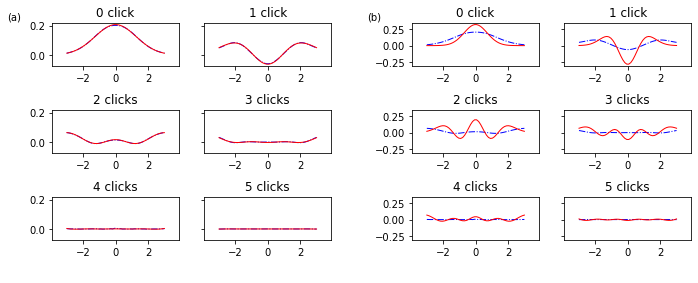

In [92]:
# TMD_noloss = detector_model('TMD', 0, 60, N=8, R={'8':.5018, '4':.506, '2':.4192})
# Pi_TMD_theo_noloss = (TMD_noloss.B@TMD_noloss.L).T

# nbar_TMD = np.linspace(.1, 60, 600)
# P_TMD_noloss = np.empty((len(nbar_TMD), 9))
# for i, nbar in enumerate(nbar_TMD):
#     P_TMD_noloss[i] = TMD_noloss.Monte_Carlo(nbar)

# cvx_TMD_noloss = cvx_POVM(P_TMD_noloss[:300], nbar_TMD[:300])
# Pi_TMD_noloss = cvx_TMD.minimize([.01])[0]


fig = plt.figure(figsize=(10, 4))
subfigs = fig.subfigures(1, 2)
subfigs[0].text(0, .89, '(a)')
subfigs[0].subplots_adjust(hspace=1)
subfigs[1].text(0, .89, '(b)')
axs0 = subfigs[0].subplots(3, 2, sharey=True)
axs1 = subfigs[1].subplots(3, 2, sharey=True)

xvec=np.linspace(-3, 3)
for i, j in product(range(3), range(2)):
    axs0[i, j].plot(xvec, qt.wigner(qt.qobj.Qobj(np.diag(Pi_TMD[:, 2*i+j])), xvec, 0).squeeze(), '-.b', lw=1)
    axs0[i, j].plot(xvec, qt.wigner(qt.qobj.Qobj(np.diag(Pi_TMD_theo[:, 2*i+j])), xvec, 0).squeeze(), 'r', lw=1)
    axs0[i, j].set_xlim(-3.9, 3.9)
    if i==0:
        axs0[i, j].set_title(f'{2*i+j} click')
    else:
        axs0[i, j].set_title(f'{2*i+j} clicks')

for i, j in product(range(3), range(2)):
    axs1[i, j].plot(xvec, qt.wigner(qt.qobj.Qobj(np.diag(Pi_TMD_noloss[:, 2*i+j])), xvec, 0).squeeze(), '-.b', lw=1)
    axs1[i, j].plot(xvec, qt.wigner(qt.qobj.Qobj(np.diag(Pi_TMD_theo_noloss[:, 2*i+j])), xvec, 0).squeeze(), 'r', lw=1)
    axs1[i, j].set_xlim(-3.9, 3.9)
    if i==0:
        axs1[i, j].set_title(f'{2*i+j} click')
    else:
        axs1[i, j].set_title(f'{2*i+j} clicks')
fig.savefig('./Reproduction/Feito2009/Figures/Fig13.pdf')

## 4.3 Lundeen, J. S. et al. Tomography of quantum detectors. Nature Phys 5, 27–30 (2009). 

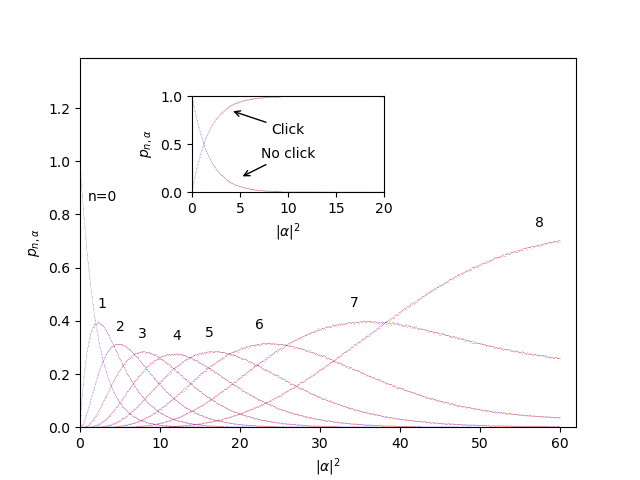

In [9]:
# 1. APD
APD = detector_model('APD', .432, 20)
Pi_APD_theo = (APD.B@APD.L).T

nbar_APD = np.linspace(.1, 20, 200)
P_APD = np.empty((len(nbar_APD), 2))
for i, nbar in enumerate(nbar_APD):
    P_APD[i] = APD.Monte_Carlo(nbar)

cvx_APD = cvx_POVM(P_APD, nbar_APD, M=30)
Pi_APD = cvx_APD.minimize([.1])[0]
P_APD_rec = utils.get_F(nbar_APD, 30, 'coherent')@Pi_APD

# 2. TMD
TMD = detector_model('TMD', .522, 60, N=8, R={'8':.5018, '4':.506, '2':.4192})
Pi_TMD_theo = (TMD.B@TMD.L).T

nbar_TMD = np.linspace(.1, 60, 600)
P_TMD = np.empty((len(nbar_TMD), 9))
for i, nbar in enumerate(nbar_TMD):
    P_TMD[i] = TMD.Monte_Carlo(nbar)

cvx_TMD = cvx_POVM(P_TMD, nbar_TMD, M=120)
Pi_TMD = cvx_TMD.minimize([.1])[0]
P_TMD_rec = utils.get_F(nbar_TMD, 120, 'coherent')@Pi_TMD

# Plot Fig.2
fig, ax1 = plt.subplots()
for n in range(9):
    ax1.scatter(nbar_TMD, P_TMD[:, n], s=.1, c='r', linewidths=0)
    ax1.plot(nbar_TMD, P_TMD_rec[:, n], 'b', lw=.1)
    if n==0:
        ax1.text(1, .85, 'n=0')
    else:
        idx = np.argmax(P_TMD[:, n])
        ax1.text(nbar_TMD[idx]*.95, P_TMD[idx, n].max()+.05, f'{n}')
ax1.set_xlabel(r'$|\alpha|^2$')
ax1.set_ylabel(r'$p_{n,\alpha}$')
ax1.set_xlim(0, 62)
ax1.set_ylim(0, 1.39)
ax1.xaxis.set_major_locator(MultipleLocator(10))
ax1.yaxis.set_major_locator(MultipleLocator(.2))

ax2 = plt.axes((.3, .6, .3, .2))
for n in range(2):
    ax2.scatter(nbar_APD, P_APD[:, n], s=.1, c='r', linewidths=0)
    ax2.plot(nbar_APD, P_APD_rec[:, n], 'b', lw=.1)
ax2.annotate('No click', (5, .15), (10, .4), arrowprops=dict(facecolor='black', arrowstyle='->'), ha='center', va='center')
ax2.annotate('Click', (4, .85), (10, .65), arrowprops=dict(facecolor='black', arrowstyle='->'), ha='center', va='center')
ax2.set_xlim(0, 20)
ax2.set_ylim(0, 1)
ax2.set_xlabel(r'$|\alpha|^2$')
ax2.set_ylabel(r'$p_{n,\alpha}$')
fig.savefig('./Reproduction/Lundeen2009/Figures/Fig2.pdf')

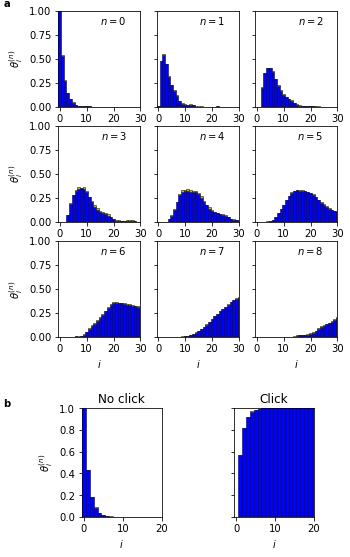

In [7]:
fig = plt.figure(figsize=(5, 8))
subfigs = fig.subfigures(2, 1, height_ratios=[3, 1])
subfigs[0].text(-.03, .89, r'$\mathbf{a}$')
subfigs[1].text(-.03, .89, r'$\mathbf{b}$')
axs0 = subfigs[0].subplots(3, 3, sharey=True)
axs1 = subfigs[1].subplots(1, 2, sharey=True, subplot_kw={'aspect':28})
i = np.arange(31)
for j, k in product(range(3), repeat=2):
    axs0[j, k].bar(i, Pi_TMD[:31, 3*j+k], width=1, color='b', edgecolor='k', linewidth=.5)
    axs0[j, k].bar(i, abs(Pi_TMD[:31, 3*j+k]-Pi_TMD_theo[:31, 3*j+k]), bottom=Pi_TMD[:31, 3*j+k], width=1, color='y', edgecolor='k', linewidth=.5)
    axs0[j, k].text(20, .9, f'$n={3*j+k}$', ha='center', va='center')
    axs0[j, k].set_xlim(-.5, 30)
    axs0[j, k].set_ylim(0, 1)
    axs0[j, k].xaxis.set_major_locator(MultipleLocator(10))
    axs0[j, k].set_xlabel('$i$')
    if k==0:
        axs0[j, k].set_ylabel(r'$\theta_i^{(n)}$')

i = np.arange(21)
for n in range(2):
    axs1[n].bar(i, Pi_APD[:21, n], width=1, color='b', edgecolor='k', linewidth=.5)
    axs1[n].bar(i, abs(Pi_APD[:21, n]-Pi_APD_theo[:21, n]), bottom=Pi_APD[:21, n], width=1, color='y', edgecolor='k', linewidth=.5)
    axs1[n].set_xlabel('$i$')
    axs1[n].set_xlim(-.5, 20)
    axs1[n].set_ylim(0, 1)
    axs1[n].xaxis.set_major_locator(MultipleLocator(10))
    if n==0:
        axs1[n].set_title('No click')
        axs1[n].set_ylabel(r'$\theta_i^{(n)}$')
    else: axs1[n].set_title('Click')

fig.savefig('./Reproduction/Lundeen2009/Figures/Fig3.pdf')

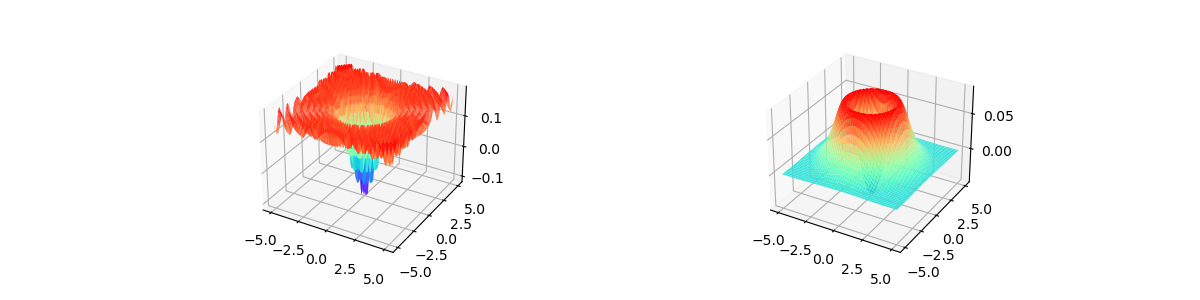

In [20]:
import qutip as qt
from matplotlib import cm

%matplotlib widget

xvec = np.linspace(-5, 5, 200)
W1_APD = qt.wigner(qt.qobj.Qobj(np.diag(Pi_APD[:, 1])), xvec, xvec)
W1_TMD = qt.wigner(qt.qobj.Qobj(np.diag(Pi_TMD[:, 1])), xvec, xvec)
fig, axes = plt.subplots(1, 2, figsize=(12,3), subplot_kw={"projection": "3d"})
X, Y = np.meshgrid(xvec, xvec)
axes[0].plot_surface(X, Y, W1_APD, cmap=cm.rainbow, linewidth=0)
axes[1].plot_surface(X, Y, W1_TMD, cmap=cm.rainbow, linewidth=0)
fig.savefig('./Reproduction/Lundeen2009/Figures/Fig4.pdf')

## 5. Teo, Y. S., Zhu, H., Englert, B.-G., Řeháček, J. & Hradil, Z. Quantum-State Reconstruction by Maximizing Likelihood and Entropy. Phys. Rev. Lett. 107, 020404 (2011). 

In [108]:
from scipy.linalg import logm
from qutip import maximally_mixed_dm

class MaxLikEnt():
    def __init__(self, Pi: list[npt.NDArray]):
        '''
        Args:
            Pi: list of POVM elements.
        Additional attributes:
            D: float, the dimension of the Hilbert space.
            message: dict, the solution message.
        '''
        self.Pi = Pi
        self.D = Pi[0].shape[0]
        
    def solve(self, f: npt.NDArray[float], lamb: float, epsilon: float, max_iter=int(1e5)) -> npt.NDArray[float]:
        '''
        Args:
            f: 1darray, the measured statistics.
            lamb: float, the weight on entropy.
            epsilon: float, the step size.
        Return:
            rho: qobj, the reconstructed density matrix.
        '''
        rho0 = maximally_mixed_dm(self.D)
        for i in range(max_iter):
            R = 0
            for j in range(len(self.Pi)):
                R += f[j]/(rho0*self.Pi[j]).tr() * self.Pi[j]
            T = R - 1 - lamb*(Qobj(logm(rho0)) - (rho0*Qobj(logm(rho0))).tr())
            if np.allclose(T*rho0, 0) and np.allclose(rho0*T, 0):
                break
            T_ = 1 + epsilon*T
            rho1 = T_ * rho0 * T_
            rho1 /= rho1.tr()
            
            rho0 = rho1
        
        status = 'success' if i<max_iter-1 else 'max_iter reached'
        self.message = {'status':status, 'num_iter':i+1}
        return rho1
def bloch(rho):
    '''
    Return the bloch vector of rho.
    '''
    return [(2*rho[1, 0]).real, (2*rho[1, 0]).imag, (2*rho[0, 0]-1).real]

def Lik(rho, f, Pi):
    '''
    Return log-likelihood divided by N.
    '''
    # _, p = measurement_statistics_povm(rho, Pi)
    p = [(rho*pi).tr() for pi in Pi]
    lik = f@np.log(p)
    return lik

In [33]:
# compare the MLME scheme with the standard ME scheme by using the simple example of a trine POM

from qutip import qeye, sigmax, sigmay, sigmaz
Pi = np.array([(1+sigmaz())/3, (1+np.sqrt(3)*sigmax()/2-sigmaz()/2)/3, (1-np.sqrt(3)*sigmax()/2-sigmaz()/2)/3])
f = [2/3, 2/9, 1/9]
maxLikEnt = MaxLikEnt(Pi)
rho = maxLikEnt.solve(f, 1e-3, .1)
print(maxLikEnt.message)
print(bloch(rho))

{'status': 'max_iter reached', 'num_iter': 100000}
[0.9998363639037905, 4.9808446894148404e-24, 0.018089925805459206]


/home/dsliu/miniconda3/envs/ml/lib/python3.9/site-packages/skimage/transform/radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
/home/dsliu/miniconda3/envs/ml/lib/python3.9/site-packages/skimage/transform/radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
/home/dsliu/miniconda3/envs/ml/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


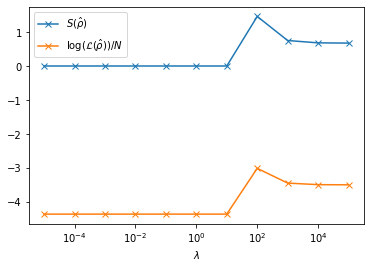

In [103]:
# Fig.1
from qutip import rand_dm, create, destroy, entropy_vn, ket2dm, wigner, Qobj
from qutip.measurement import measurement_statistics_povm
from skimage.transform import radon, iradon
from tqdm.contrib.concurrent import process_map
from functools import partial

N = int(1e4)
D = 5

rho = rand_dm(D)
theta = [0, np.pi/4, np.pi/2, 3*np.pi/4] # 4 elements
def simulate(theta: list, D: int):
    Pi = []
    for t in theta:
        x_theta = 1/np.sqrt(2)*(destroy(D)*np.exp(-1j*t)+create(D)*np.exp(1j*t))
        eigenvals, eigenvecs = x_theta.eigenstates()
        for eig in eigenvecs:
            Pi.append(ket2dm(eig)/len(theta)) # normalize by divided by len(theta)
    return eigenvals, Pi
eigenvals, Pi = simulate(theta, D)

W = wigner(rho, eigenvals, eigenvals)
P_x_theta = (radon(W, theta).T).flatten()
P_x_theta /= P_x_theta.sum() # normalize

samples = np.random.default_rng().choice(len(P_x_theta), size=N, p=P_x_theta)
f, _ = np.histogram(samples, bins=range(len(P_x_theta)+1), density=True)
maxLikEnt = MaxLikEnt(Pi)

if __name__=='__main__':
    lamb = np.logspace(-5, 5, 11)
    rho_hat = process_map(partial(maxLikEnt.solve, f, epsilon=1e-2), lamb)

fig, ax = plt.subplots()
ax.semilogx(lamb, list(map(entropy_vn, rho_hat)), marker='x', label=r'$S(\hat{\rho})$')
ax.semilogx(lamb, list(map(partial(Lik, f=f, Pi=Pi), rho_hat)), marker='x', label=r'log$(\mathcal{L}(\hat{\rho}))/N$')
ax.set_xlabel(r'$\lambda$')
ax.legend()

In [ ]:
from qutip import tracedist
D = range(2, 21)
D_tr = map(tracedist, rho_hat, rho)
W_00 = map(wigner, rho_hat, 0, 0)

fig, ax = plt.subplots()
ax.plot(D, D_tr, '^', label=r'$\bar{D}_{tr}$')
ax.plot(D, W_00, 'x', label=r'$\bar{W}_{00}$')